In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import cm
from jupyterthemes import jtplot
jtplot.style()

# Exercise 10

- Load the olivetti faces dataset, split it into training, validation and test set then cluster the images using kmeans. 
- Visualize the clusters, are the same faces in each cluster?

In [2]:
X, y = datasets.fetch_olivetti_faces(shuffle=True, return_X_y=True)

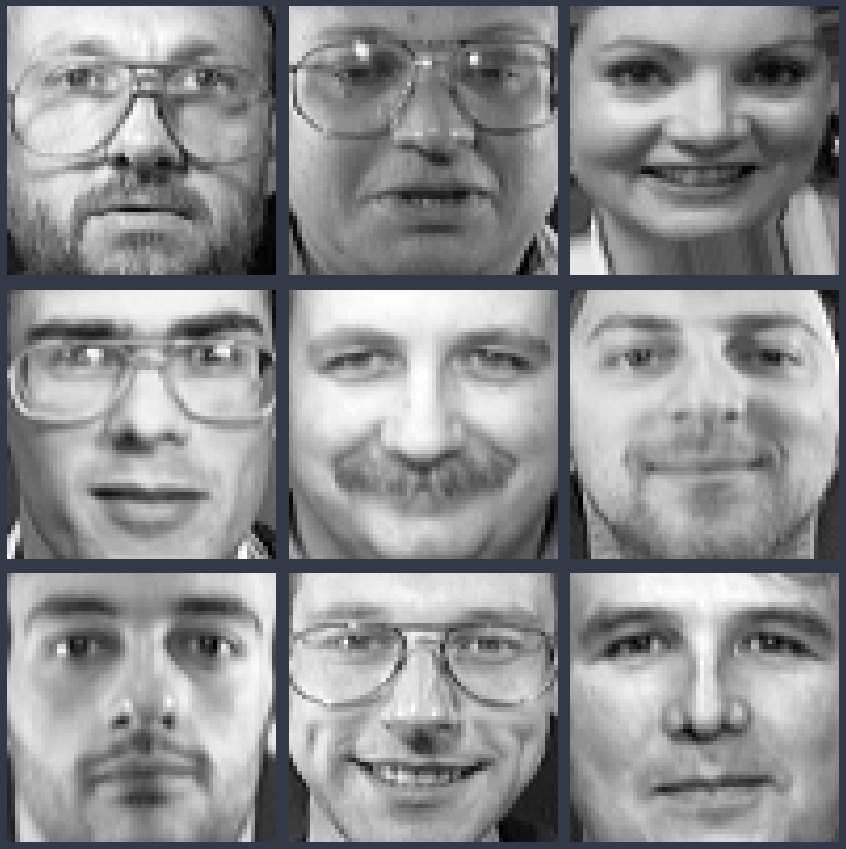

In [3]:
def plot_faces(X, title=None):
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(X[idx], cmap='gray')
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

imgs = X[:9].reshape(9, 64, 64)
plot_faces(imgs)

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=16, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=16, stratify=y_train_full)

In [5]:
kmeans_list = [KMeans(n_clusters=k).fit(X_train) for k in range(2, 31)]
inertia_list = [km.inertia_ for km in kmeans_list]
silhouette_scores = [silhouette_score(X_train, km.labels_) for km in kmeans_list]

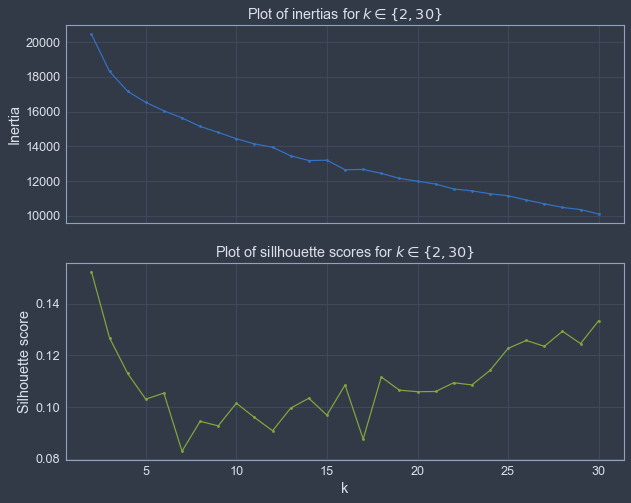

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(2, 31), inertia_list, '.-')
ax1.set_xticklabels([])
ax1.set_ylabel("Inertia")
ax1.set_xlabel("")
ax1.set_title("Plot of inertias for $k\in  \{2, 30\}$")

ax2.plot(range(2, 31), silhouette_scores, 'g.-')
ax2.set_ylabel("Silhouette score")
ax2.set_xlabel("k")
ax2.set_title("Plot of sillhouette scores for $k\in  \{2, 30\}$")
plt.show()

From the plots above looks like k=3 is reasonable. Naturally, k=29 and k=30 have better sillhouette but at this stage it may be difficult to identify the faces

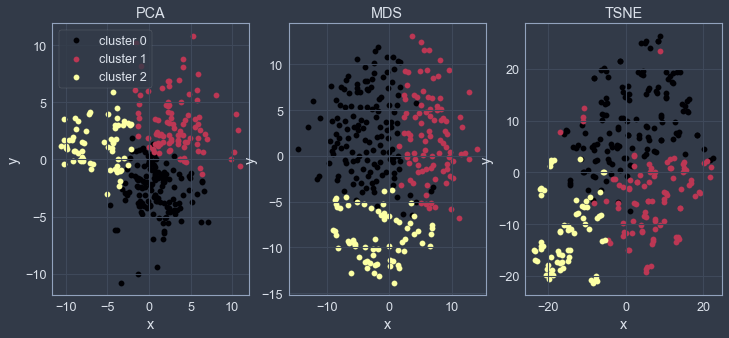

In [7]:
km = KMeans(n_clusters=3, n_init=20)
km.fit(X_train)
labels = km.labels_

reductions = [PCA(n_components=2), MDS(n_components=2), TSNE(n_components=2)]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
cmap_ = cm.get_cmap("inferno", 3)

for reduction, ax in zip(reductions, axes):
    X_reduced = reduction.fit_transform(X_train)
    
    for i in np.unique(labels):
        ax.scatter(
            X_reduced[labels==i, 0], X_reduced[labels==i, 1], color=cmap_(i), label=f'cluster {i}')
        
    if reduction in reductions[:1]:
            ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"{type(reduction).__name__}")

Let's plot some faces from each cluster and see if they are similar

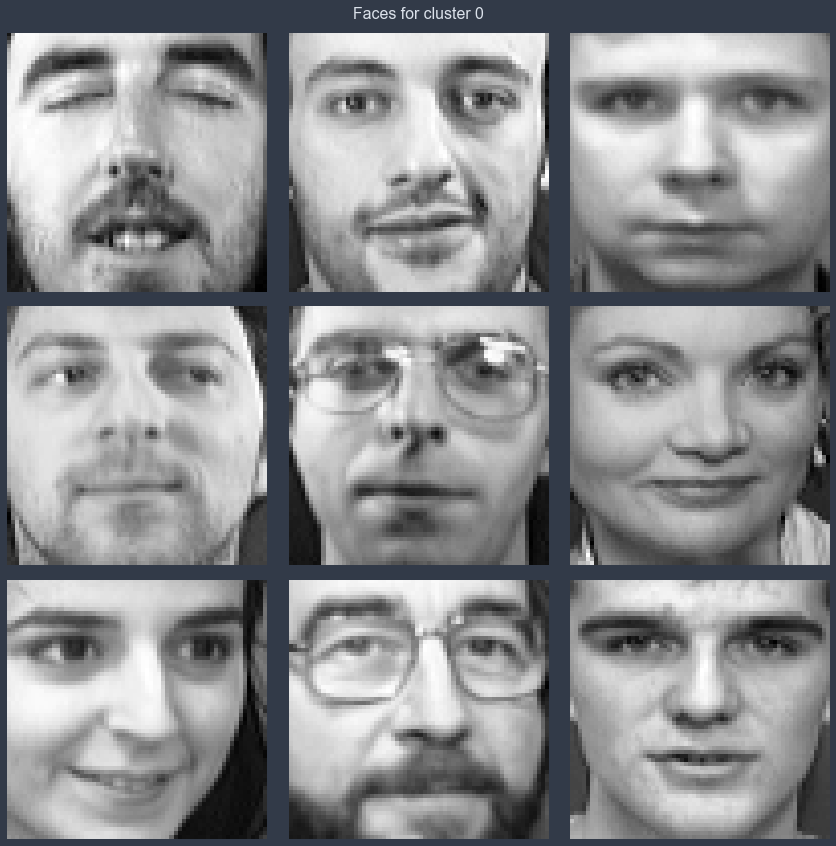

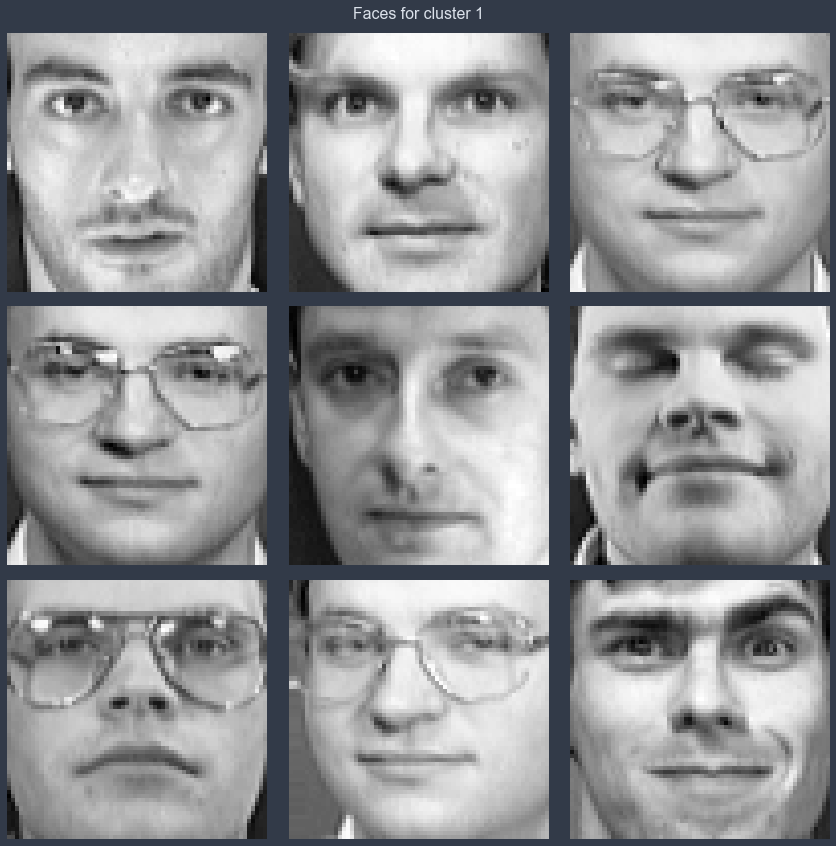

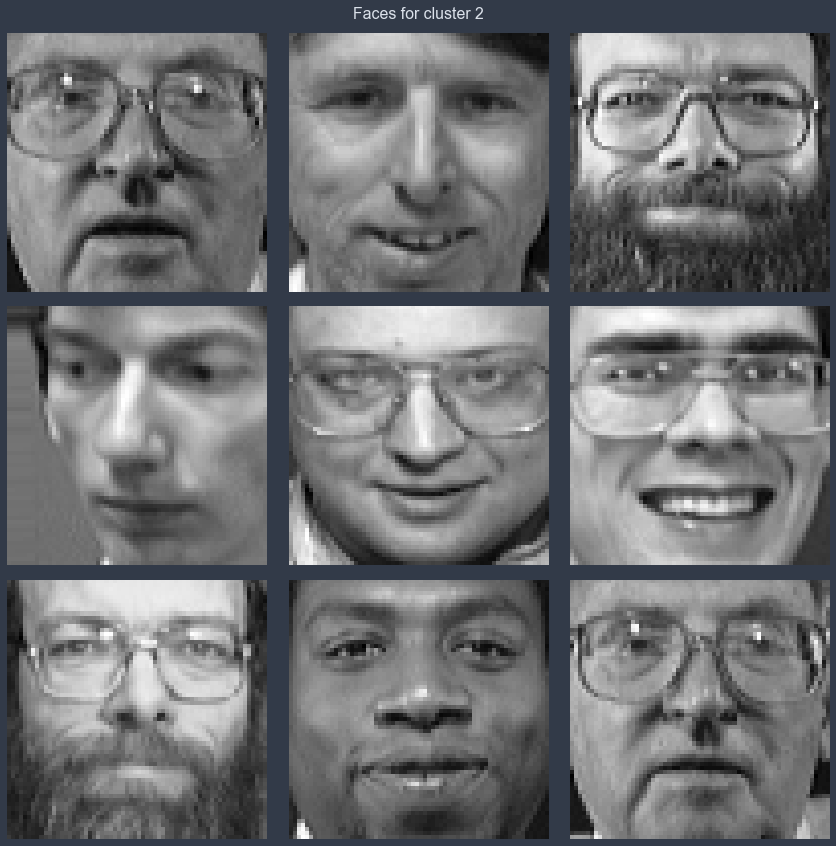

In [8]:
for i in np.unique(labels):
    sample = X_train[labels==i][:9].reshape(9, 64, 64)
    plot_faces(sample, title=f"Faces for cluster {i}")

There are some images that are similar enough to each other in each cluster. Cluster 0 seems more arbitrary than 1 and 2

# Exercise 11

- Train a classifier to predict which person is represented in each picture. Evaluate it on the validation set
- Use Kmeans as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance. 
- Try appending the features from the reduced set to the original features and re-evaluating the classifier

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action="ignore")  # supress sklearn warning

svc_param_grid = {
    "C": np.arange(0, 1, 0.1),
    "kernel": ["linear", "rbf"],
    "random_state": [17]}
svc_cv = GridSearchCV(SVC(), svc_param_grid, cv=5)
svc_cv.fit(X_train, y_train)
svc_clf = svc_cv.best_estimator_
print(f"SVC validation score: {svc_clf.score(X_valid, y_valid):.2%}")

forest_grid = {
    "n_estimators": range(70, 120, 10),
    "min_samples_split": range(2, 6),
    "random_state": [17],
    "n_jobs": [-1]}
rand_cv = GridSearchCV(RandomForestClassifier(), forest_grid, cv=5)
rand_cv.fit(X_train, y_train)
rand_clf = rand_cv.best_estimator_
print(f"RandomForest validation score: {rand_clf.score(X_valid, y_valid):.2%}")

log_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.arange(0, 1, 0.1),
    "random_state": [17],
    "n_jobs": [-1]}
log_cv = GridSearchCV(LogisticRegression(), log_grid, cv=5)
log_cv.fit(X_train, y_train)
log_clf = log_cv.best_estimator_
print(f"LogisticRegression validation score: {log_clf.score(X_valid, y_valid):.2%}")

SVC validation score: 94.44%
RandomForest validation score: 85.19%
LogisticRegression validation score: 90.74%


Now for adding KMeans as a preprocessing step

In [45]:
from sklearn.pipeline import Pipeline

pipeline =  Pipeline([
    ("preprocessing", KMeans()),
    ("classifier", SVC(**svc_cv.best_params_))
])
param_grid = {"preprocessing__n_clusters": range(2, 100)}
pipeline_cv = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)
print(f"GridSearch found Kmeans with k={pipeline_cv.best_params_['preprocessing__n_clusters']} yielded best score")
print(f"SVC with KMeans validation score: {pipeline_cv.best_estimator_.score(X_valid, y_valid):.2%}")

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 10.1min finished


GridSearch found Kmeans with k=92 yielded best score
SVC with KMeans validation score: 90.74%


Now let's use Kmeans to create new features and combine them with the original ones

In [67]:
n_clusters = pipeline_cv.best_params_["preprocessing__n_clusters"]

print(f"Preprocessing data with KMeans, k={n_clusters}")
best_km = KMeans(n_clusters=n_clusters, n_init=30)
X_train_km = best_km.fit_transform(X_train)
X_train_expanded = np.c_[X_train, X_train_km]
X_valid_expanded = np.c_[X_valid, best_km.transform(X_valid)]

print("Fitting models...")
svc_clf_2 = SVC(**svc_cv.best_params_)
svc_clf_2.fit(X_train_expanded, y_train)
print(f"SVC with additional features validation score: {svc_clf_2.score(X_valid_expanded, y_valid):.2%}")

rnd_clf_2 = RandomForestClassifier(**rand_cv.best_params_)
rnd_clf_2.fit(X_train_expanded, y_train)
print(f"RandomForest with additional features validation score: {rnd_clf_2.score(X_valid_expanded, y_valid):.2%}")

log_clf_2 = LogisticRegression(**log_cv.best_params_)
log_clf_2.fit(X_train_expanded, y_train)
print(f"LogisticRegression with additional features validation score: {log_clf_2.score(X_valid_expanded, y_valid):.2%}")

Preprocessing data with KMeans, k=92
Fitting models...
SVC with additional features validation score: 92.59%
RandomForest with additional features validation score: 88.89%
LogisticRegression with additional features validation score: 94.44%


It was effective adding the extra features, however I had to do a few runs of this cell to get better results. Now let's compare all models on the test set

In [72]:
models = [svc_clf, rand_clf, log_clf, svc_clf_2, rnd_clf_2, log_clf_2]
model_names = ["base_svc", "base_random_forest", "base_logistic_regression", "expanded_svc", "expanded_random_forest", "expanded_logistic_regression"]

X_test_expanded = np.c_[X_test, best_km.transform(X_test)]
for model, name in zip(models, model_names):
    X_test_print = X_test_expanded if name in model_names[-3:] else X_test
    print(f"{name} with test score: {model.score(X_test_print, y_test):.2%}")

base_svc with test score: 100.00%
base_random_forest with test score: 97.50%
base_logistic_regression with test score: 97.50%
expanded_svc with test score: 92.50%
expanded_random_forest with test score: 90.00%
expanded_logistic_regression with test score: 97.50%
